In [3]:
import os
import sys
import numpy as np

import matplotlib.pyplot         as plt
import mlem.mlem_reconstruct     as mr
import antea.image.fom_functions as fomf

#sys.stdout = open(os.devnull, "w") ## Prevents from printing

In [4]:
path_to_mlem     = '/software/tofpet3d/lib/libmlem.so'
reco_prefix_base = '/home/rolucar/full_body_phantom_paper/images_reco/phot_range3mm/'

ths        = [0.25]
tofs       = [140]#, 150]
n_coinc    = [100000, 500000, 1000000, 5000000, 10000000, 20000000, 30000000, 35274951]
n_iter     = 60
save_every = 2

#sys.stdout = sys.__stdout__ ##Allows printing again

In [5]:
def read_images(th, tof, nc):
    rec = mr.MLEMReconstructor(libpath=path_to_mlem)
    rec.prefix = reco_prefix_base + f'/{nc}coinc/im_th{th}_TOF{tof}ps_phot_like_phot_range3mm_{nc}coinc_iter'
    return np.array([rec.read_image(i) for i in range(0, n_iter, save_every)])

from collections import namedtuple

tof_thr_nc = namedtuple('tof_thr_nc', 'tof, th, nc')
the_images = {tof_thr_nc(tof=tof, th=th, nc=nc): read_images(th, tof, nc) 
              for tof in tofs 
              for th in ths
              for nc in n_coinc}

Sensitivity matrix not specified: assuming a matrix of 1s.
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Sensitivity matrix not specified: assuming a matrix of 1s.
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes


In [6]:
the_images;

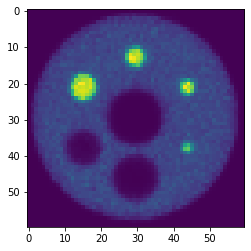

In [8]:
plt.imshow(the_images[(140, 0.25, 35274951)][6,:,:,29]);

In [9]:
def imshow_slice_integrated_along_z(ax, th, tof, nc, it, z_slice):
    if it < 1:
        it = 1
    image_slice = the_images[tof_thr_nc(tof=tof, th=th, nc=nc)][int(it/save_every-1),:,:,z_slice]
    im_integrated_along_z = np.sum(image_slice, axis=2).transpose()
    fig0 = ax.imshow(im_integrated_along_z, origin='lower')
    title = f'{nc} coincidences'
    ax.set_title(title, fontsize=17)
    ax.set_xlabel('X (mm)', fontsize=15)
    ax.set_ylabel('Y (mm)', fontsize=15)
    #fig.colorbar(fig0, ax=ax, label='Events')

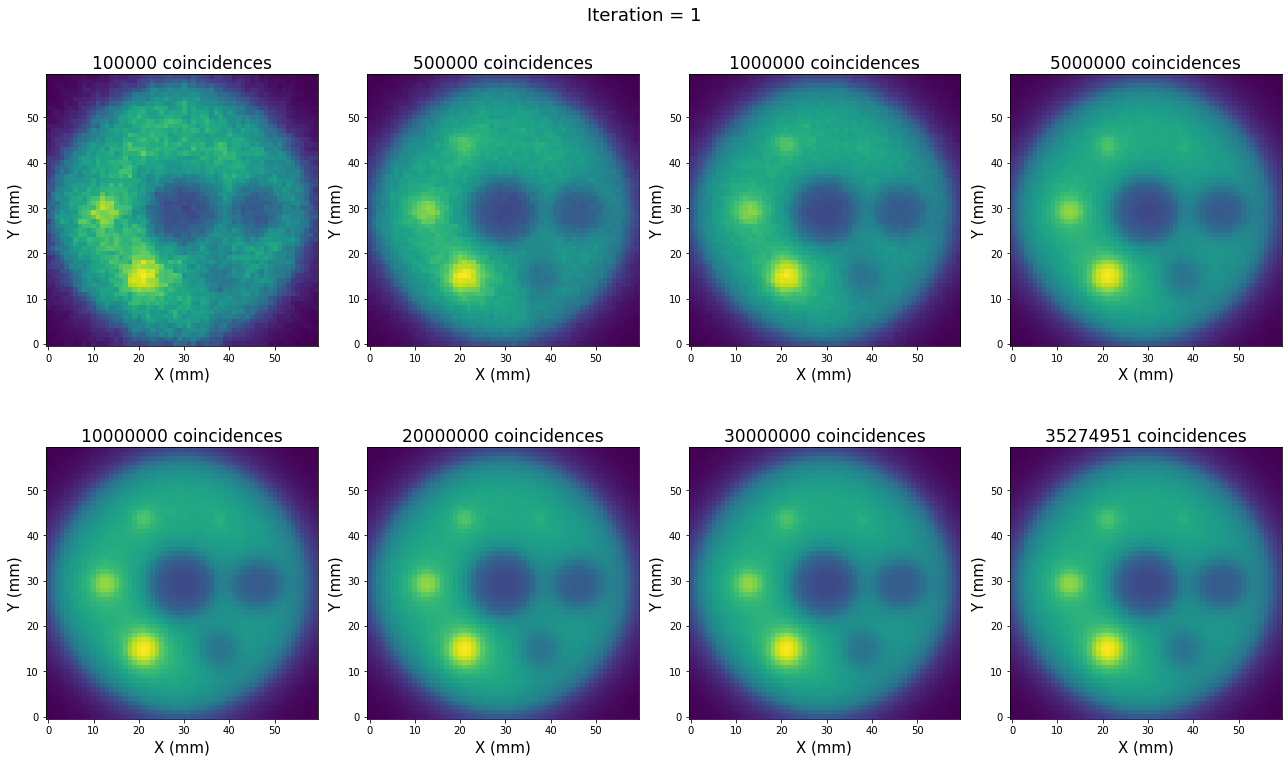

In [10]:
it       = 0
z_slice  = slice(25,35)
fig, axs = plt.subplots(2,4, figsize=(18, 11))
fig.suptitle(f'Iteration = {it+1}', fontsize=18)
for ax, nc in zip(axs.flatten(), n_coinc):
    imshow_slice_integrated_along_z(ax, ths[0], tof=tofs[0], nc=nc, it=it, z_slice=z_slice)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

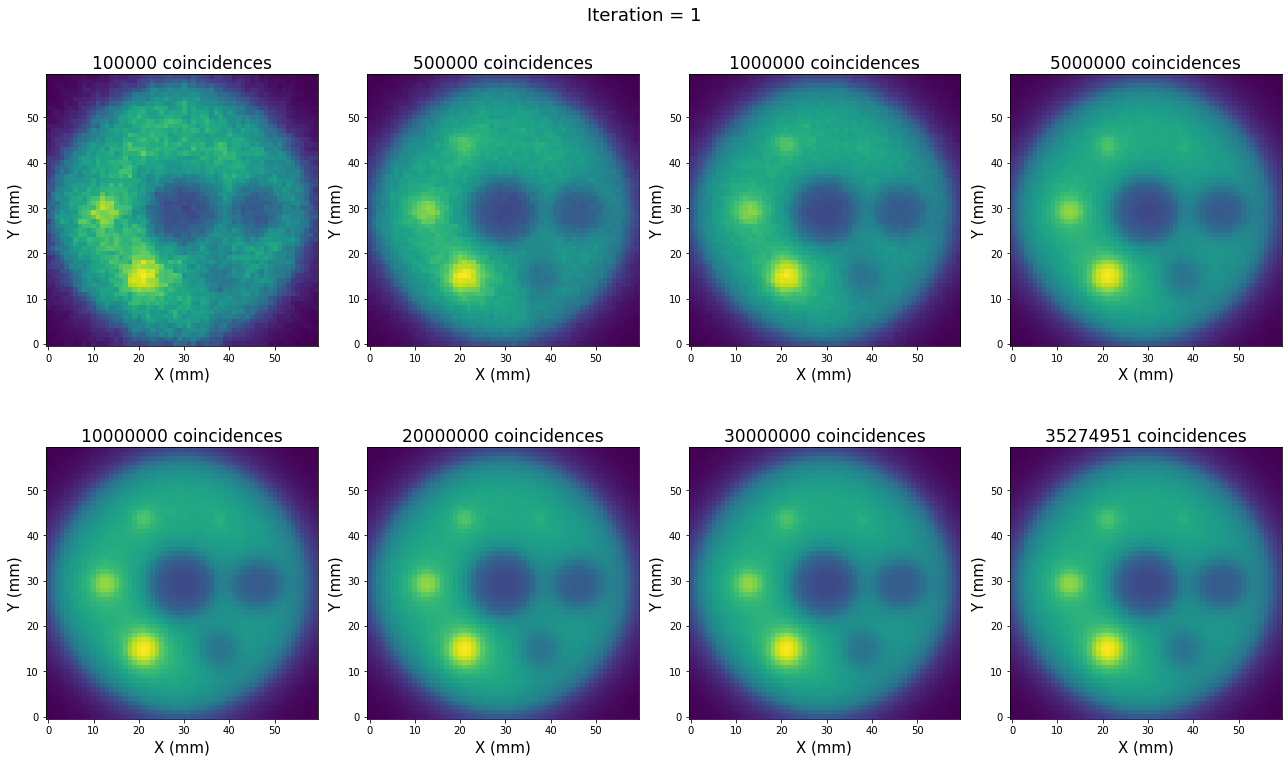

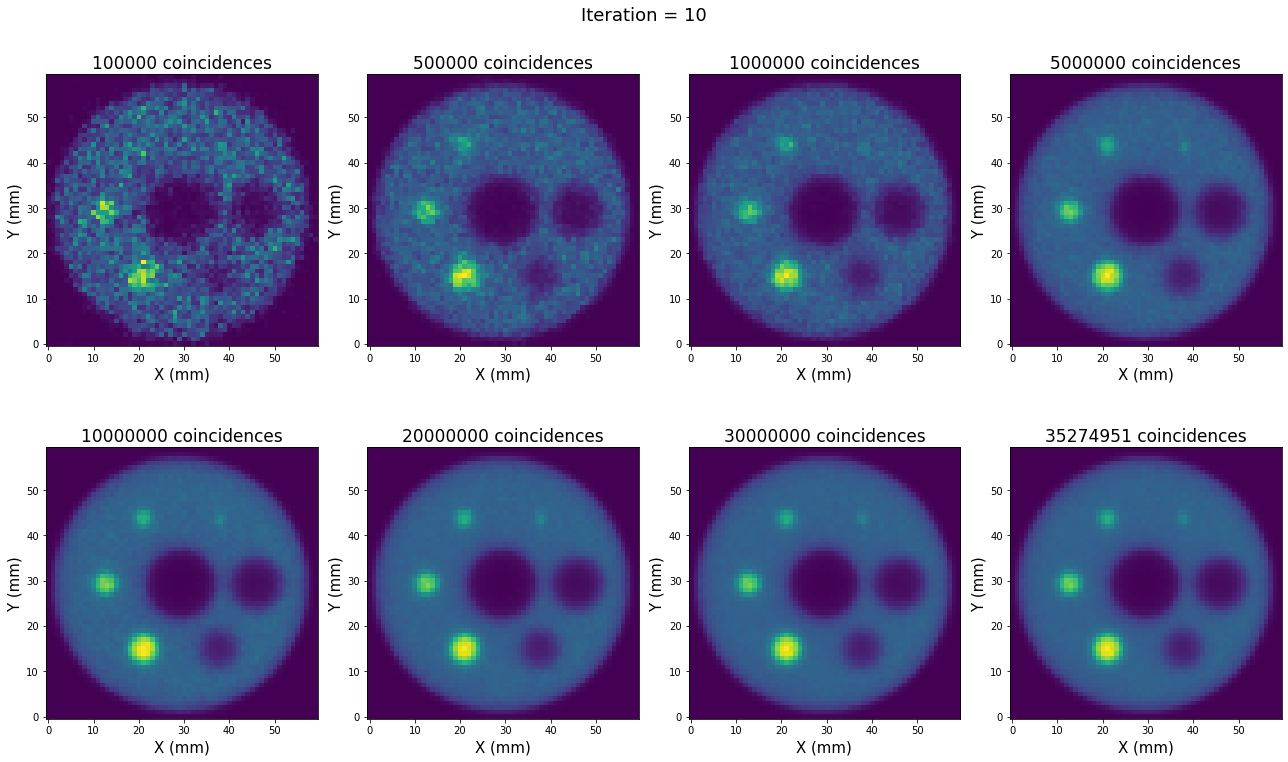

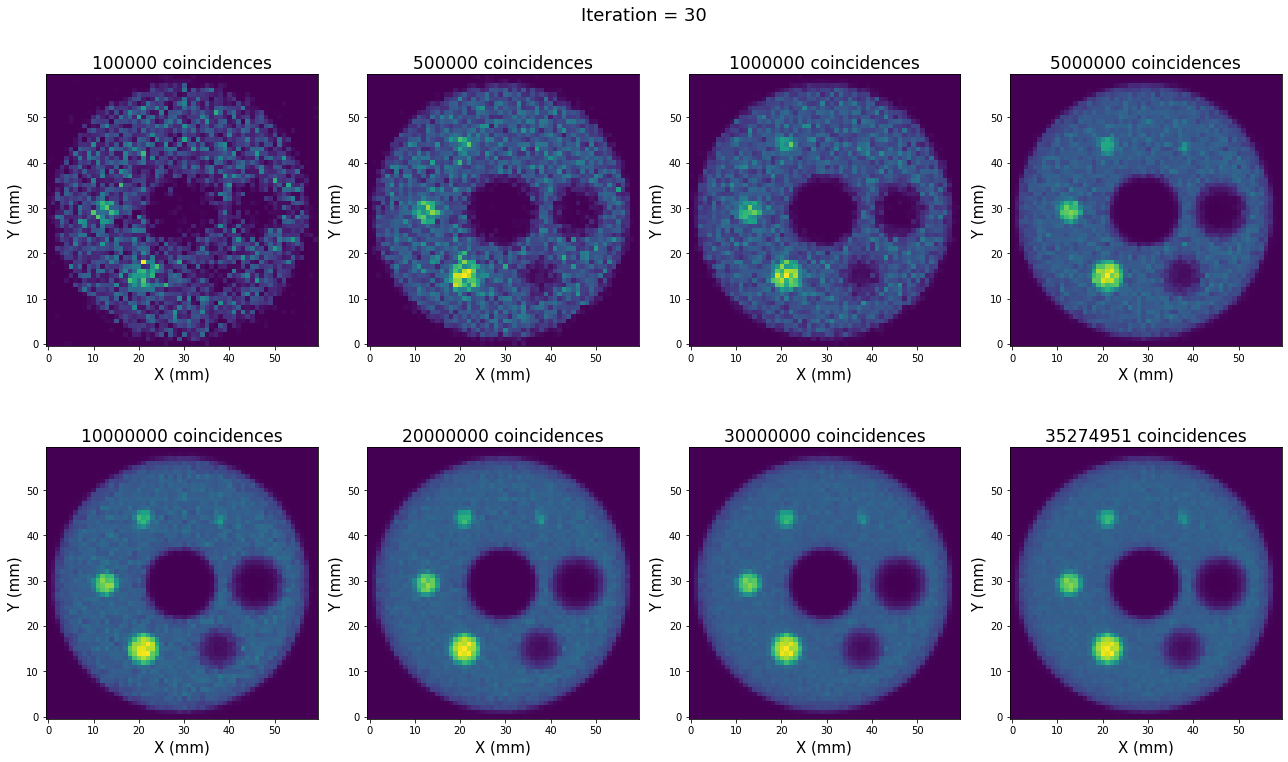

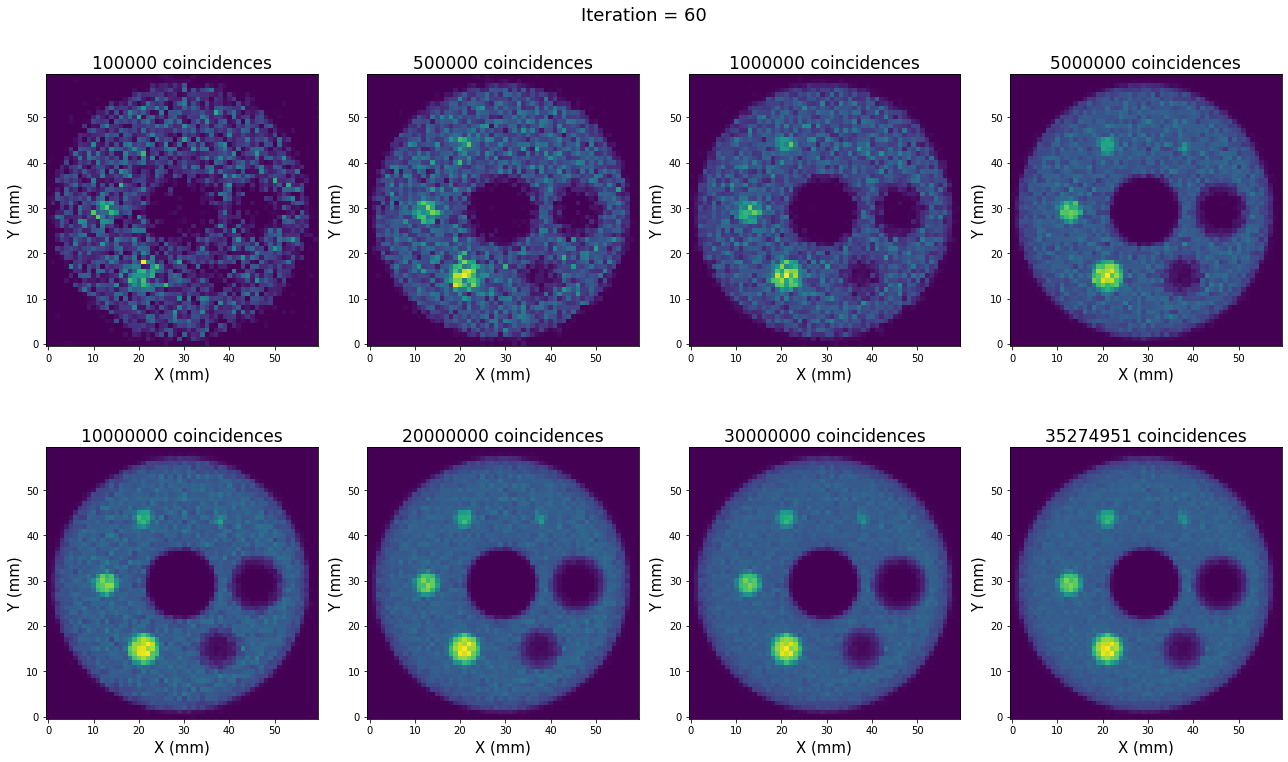

In [11]:
z_slice = slice(25,35)    
for it in [0, 9, 29, 59]:
    fig, axs = plt.subplots(2,4, figsize=(18, 11))
    fig.suptitle(f'Iteration = {it+1}', fontsize=18)
    for ax, nc in zip(axs.flatten(), n_coinc):
        imshow_slice_integrated_along_z(ax, ths[0], tof=tofs[0], nc=nc, it=it, z_slice=z_slice)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

### Images parameters:

In [12]:
sig_intensity  =  4
bckg_intensity =  1
radial_pos     = 50.
bckg_radius    =  4.
phi0           = np.pi/6
phi_step       = np.pi/3
n_phi          = 6

hot_radii   = [4., 6.5, 8.5, 11.]
cold_radii  = [14., 18.5]
all_radii   = hot_radii + cold_radii

hot_angles  = [np.pi/3, 2*np.pi/3, 3*np.pi/3, 4*np.pi/3]
cold_angles = [5*np.pi/3, 6*np.pi/3]

x_size = y_size = z_size = 180
x_bins = y_bins = z_bins =  60

radii  = hot_radii  + cold_radii
angles = hot_angles + cold_angles

In [13]:
num_hot     = 4
num_cold    = 2
num_spheres = num_hot + num_cold

sph_thresh_tof_nc = namedtuple('sph_thresh_tof_nc', 'sph, th, tof, nc')
snr_err           = namedtuple('snr_err'          , 'snrs, errs')

def get_snrs(images, tof_thr_nc, n_sph):
    calculate_snrs_and_errs = lambda images: fomf.snr3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                        bckg_radius, phi0, phi_step, n_phi, 
                                                        x_size, y_size, z_size,
                                                        x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_snrs_and_errs, images[tof_thr_nc]))
    snrs = [r[0] for r in all_images]
    errs = [e[1] for e in all_images]
    print(tof_thr_nc, n_sph)
    return snr_err(snrs=snrs, errs=errs)

snrs = {sph_thresh_tof_nc(sph=n_sph, th=th, tof=tof, nc=nc) :
        get_snrs(the_images, tof_thr_nc(tof=tof, th=th, nc=nc), n_sph)
        for tof   in tofs
        for th    in ths
        for nc    in n_coinc
        for n_sph in range(num_spheres)}

tof_thr_nc(tof=140, th=0.25, nc=100000) 0
tof_thr_nc(tof=140, th=0.25, nc=100000) 1
tof_thr_nc(tof=140, th=0.25, nc=100000) 2
tof_thr_nc(tof=140, th=0.25, nc=100000) 3
tof_thr_nc(tof=140, th=0.25, nc=100000) 4
tof_thr_nc(tof=140, th=0.25, nc=100000) 5
tof_thr_nc(tof=140, th=0.25, nc=500000) 0
tof_thr_nc(tof=140, th=0.25, nc=500000) 1
tof_thr_nc(tof=140, th=0.25, nc=500000) 2
tof_thr_nc(tof=140, th=0.25, nc=500000) 3
tof_thr_nc(tof=140, th=0.25, nc=500000) 4
tof_thr_nc(tof=140, th=0.25, nc=500000) 5
tof_thr_nc(tof=140, th=0.25, nc=1000000) 0
tof_thr_nc(tof=140, th=0.25, nc=1000000) 1
tof_thr_nc(tof=140, th=0.25, nc=1000000) 2
tof_thr_nc(tof=140, th=0.25, nc=1000000) 3
tof_thr_nc(tof=140, th=0.25, nc=1000000) 4
tof_thr_nc(tof=140, th=0.25, nc=1000000) 5
tof_thr_nc(tof=140, th=0.25, nc=5000000) 0
tof_thr_nc(tof=140, th=0.25, nc=5000000) 1
tof_thr_nc(tof=140, th=0.25, nc=5000000) 2
tof_thr_nc(tof=140, th=0.25, nc=5000000) 3
tof_thr_nc(tof=140, th=0.25, nc=5000000) 4
tof_thr_nc(tof=140, th=

In [14]:
from typing import Sequence
from typing import Dict

sel_n_iter = 16
def plot_snr_sphs_nc(snrs:    Dict[sph_thresh_tof_nc, snr_err], 
                     spheres: Sequence[int], 
                     th:      int, 
                     tof:     int,
                     n_coinc: Sequence[float]):
    it_wanted = int(sel_n_iter/save_every)-1
    for n_sphere in spheres:
        sphs     = np.array([snrs[sph_thresh_tof_nc(sph = n_sphere,
                                                    th  = ths[0],
                                                    tof = tofs[0],
                                                    nc  = nc)].snrs[it_wanted:it_wanted+1]
                             for nc in n_coinc]).reshape(1,8)[0]

        sphs_err = np.array([snrs[sph_thresh_tof_nc(sph = n_sphere,
                                                    th  = ths[0],
                                                    tof = tofs[0],
                                                    nc  = nc)].errs[it_wanted:it_wanted+1]
                             for nc in n_coinc]).reshape(1,8)[0]

        lab    = f'sph{n_sphere}, ({all_radii[n_sphere]} rad)'
        plt.errorbar(x       = np.array(n_coinc),
                     y       = sphs,
                     yerr    = sphs_err,
                     xerr    = None,
                     marker  = 's', 
                     capsize = 3,
                     label   = lab)

## SNR vs number of coincidences

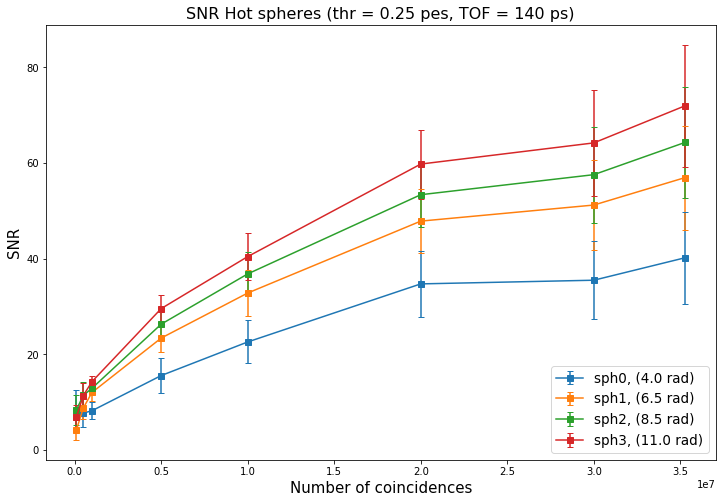

In [15]:
plt.figure(figsize=(12,8))
plot_snr_sphs_nc(snrs, range(4), ths[0], tof=tofs[0], n_coinc=n_coinc)
plt.title(f'SNR Hot spheres (thr = {ths[0]} pes, TOF = 140 ps)', fontsize=16)
plt.xlabel('Number of coincidences', fontsize=15)
plt.ylabel('SNR', fontsize=15)
plt.legend(loc=4, fontsize=13.5, ncol=1);

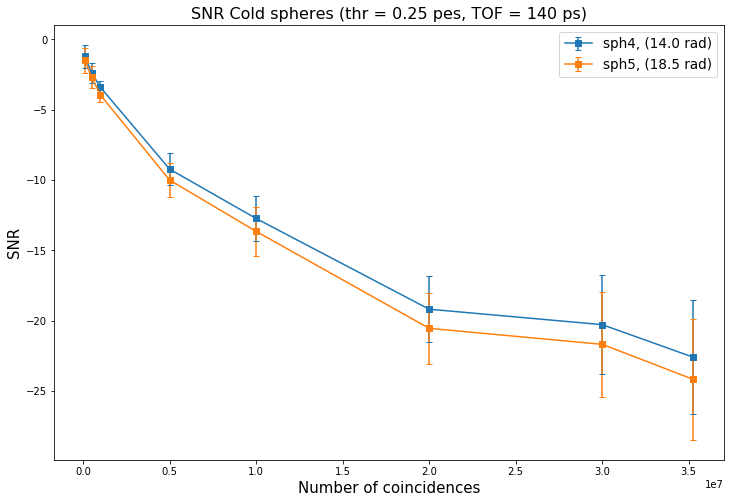

In [16]:
plt.figure(figsize=(12,8))
plot_snr_sphs_nc(snrs, range(4, 6), ths[0], tof=tofs[0], n_coinc=n_coinc)
plt.title(f'SNR Cold spheres (thr = {ths[0]} pes, TOF = 140 ps)', fontsize=16)
plt.xlabel('Number of coincidences', fontsize=15)
plt.ylabel('SNR', fontsize=15)
plt.legend(loc=1, fontsize=13.5, ncol=1);

## CRC vs number of coincidences:

In [17]:
crc_err = namedtuple('crc_err', 'crcs, errs')
sig_intensity  =  4
bckg_intensity =  1

def get_crcs(images, tof_thr_nc, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_hot3d(images, sig_intensity, bckg_intensity, 
                                                            radii[n_sph], radial_pos, angles[n_sph], 
                                                            bckg_radius, phi0, phi_step, n_phi, 
                                                            x_size, y_size, z_size,
                                                            x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[tof_thr_nc]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(tof_thr_nc, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs = {sph_thresh_tof_nc(sph=n_sph, th=th, tof=tof, nc=nc):
        get_crcs(the_images, tof_thr_nc(tof=tof, th=th, nc=nc), n_sph)
        for tof   in tofs
        for th    in ths
        for nc    in n_coinc
        for n_sph in range(4)}

tof_thr_nc(tof=140, th=0.25, nc=100000) 0
tof_thr_nc(tof=140, th=0.25, nc=100000) 1
tof_thr_nc(tof=140, th=0.25, nc=100000) 2
tof_thr_nc(tof=140, th=0.25, nc=100000) 3
tof_thr_nc(tof=140, th=0.25, nc=500000) 0
tof_thr_nc(tof=140, th=0.25, nc=500000) 1
tof_thr_nc(tof=140, th=0.25, nc=500000) 2
tof_thr_nc(tof=140, th=0.25, nc=500000) 3
tof_thr_nc(tof=140, th=0.25, nc=1000000) 0
tof_thr_nc(tof=140, th=0.25, nc=1000000) 1
tof_thr_nc(tof=140, th=0.25, nc=1000000) 2
tof_thr_nc(tof=140, th=0.25, nc=1000000) 3
tof_thr_nc(tof=140, th=0.25, nc=5000000) 0
tof_thr_nc(tof=140, th=0.25, nc=5000000) 1
tof_thr_nc(tof=140, th=0.25, nc=5000000) 2
tof_thr_nc(tof=140, th=0.25, nc=5000000) 3
tof_thr_nc(tof=140, th=0.25, nc=10000000) 0
tof_thr_nc(tof=140, th=0.25, nc=10000000) 1
tof_thr_nc(tof=140, th=0.25, nc=10000000) 2
tof_thr_nc(tof=140, th=0.25, nc=10000000) 3
tof_thr_nc(tof=140, th=0.25, nc=20000000) 0
tof_thr_nc(tof=140, th=0.25, nc=20000000) 1
tof_thr_nc(tof=140, th=0.25, nc=20000000) 2
tof_thr_nc(t

In [18]:
def get_crcs_cold(images, tof_thr_nc, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_cold3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                             bckg_radius, phi0, phi_step, n_phi, 
                                                             x_size, y_size, z_size,
                                                             x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[tof_thr_nc]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(tof_thr_nc, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs_cold = {sph_thresh_tof_nc(sph=n_sph, th=th, tof=tof, nc=nc):
             get_crcs_cold(the_images, tof_thr_nc(tof=tof, th=th, nc=nc), n_sph)
             for tof   in tofs
             for th    in ths
             for nc    in n_coinc
             for n_sph in range(4,6)}

tof_thr_nc(tof=140, th=0.25, nc=100000) 4
tof_thr_nc(tof=140, th=0.25, nc=100000) 5
tof_thr_nc(tof=140, th=0.25, nc=500000) 4
tof_thr_nc(tof=140, th=0.25, nc=500000) 5
tof_thr_nc(tof=140, th=0.25, nc=1000000) 4
tof_thr_nc(tof=140, th=0.25, nc=1000000) 5
tof_thr_nc(tof=140, th=0.25, nc=5000000) 4
tof_thr_nc(tof=140, th=0.25, nc=5000000) 5
tof_thr_nc(tof=140, th=0.25, nc=10000000) 4
tof_thr_nc(tof=140, th=0.25, nc=10000000) 5
tof_thr_nc(tof=140, th=0.25, nc=20000000) 4
tof_thr_nc(tof=140, th=0.25, nc=20000000) 5
tof_thr_nc(tof=140, th=0.25, nc=30000000) 4
tof_thr_nc(tof=140, th=0.25, nc=30000000) 5
tof_thr_nc(tof=140, th=0.25, nc=35274951) 4
tof_thr_nc(tof=140, th=0.25, nc=35274951) 5


In [19]:
def plot_crc_sphs_nc(crcs:    Dict[sph_thresh_tof_nc, crc_err], 
                     spheres: Sequence[int], 
                     th:      int, 
                     tof:     int,
                     n_coinc: Sequence[float]):
    it_wanted = int(sel_n_iter/save_every)-1
    for n_sphere in spheres:
        sphs     = np.array([crcs[sph_thresh_tof_nc(sph = n_sphere,
                                                    th  = ths[0],
                                                    tof = tofs[0],
                                                    nc  = nc)].crcs[it_wanted:it_wanted+1]
                             for nc in n_coinc]).reshape(1,8)[0]

        sphs_err = np.array([crcs[sph_thresh_tof_nc(sph = n_sphere,
                                                    th  = ths[0],
                                                    tof = tofs[0],
                                                    nc  = nc)].errs[it_wanted:it_wanted+1]
                             for nc in n_coinc]).reshape(1,8)[0]

        lab    = f'sph{n_sphere}, ({all_radii[n_sphere]} rad)'
        plt.errorbar(x       = np.array(n_coinc),
                     y       = sphs,
                     yerr    = sphs_err,
                     xerr    = None,
                     marker  = 's', 
                     capsize = 3,
                     label   = lab)

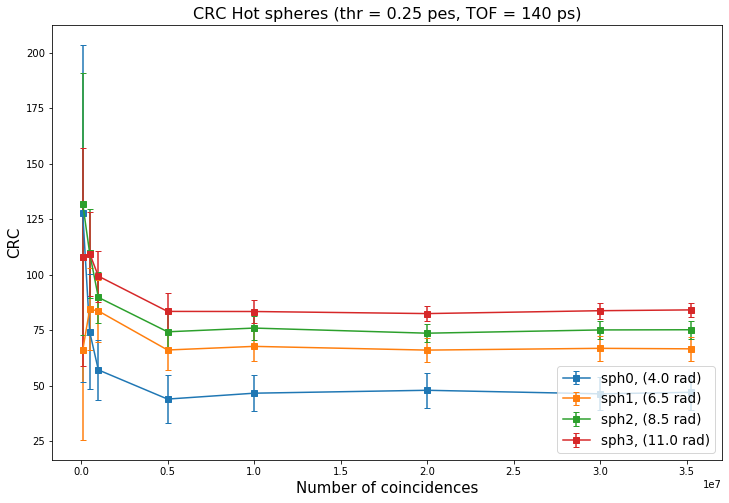

In [20]:
plt.figure(figsize=(12,8))
plot_crc_sphs_nc(crcs, range(4), ths[0], tof=tofs[0], n_coinc=n_coinc)
#plot_crc_sphs_nc(crcs_cold, range(4,6), ths[0], tof=tofs[0], n_coinc=n_coinc)
plt.title(f'CRC Hot spheres (thr = {ths[0]} pes, TOF = 140 ps)', fontsize=16)
plt.xlabel('Number of coincidences', fontsize=15)
plt.ylabel('CRC', fontsize=15)
plt.legend(loc=4, fontsize=13.5, ncol=1);

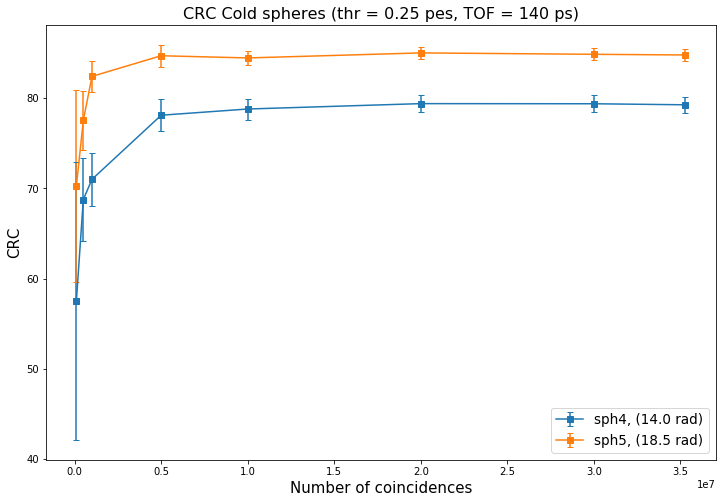

In [21]:
plt.figure(figsize=(12,8))
#plot_crc_sphs_nc(crcs, range(4), ths[0], tof=tofs[0], n_coinc=n_coinc)
plot_crc_sphs_nc(crcs_cold, range(4,6), ths[0], tof=tofs[0], n_coinc=n_coinc)
plt.title(f'CRC Cold spheres (thr = {ths[0]} pes, TOF = 140 ps)', fontsize=16)
plt.xlabel('Number of coincidences', fontsize=15)
plt.ylabel('CRC', fontsize=15)
plt.legend(loc=4, fontsize=13.5, ncol=1);